### Import Libraries

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

from datasets import load_dataset
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer, DataCollatorWithPadding

### Load Data

In [4]:
# Load a subset of the 'amazon_polarity'
amazon_train = load_dataset('amazon_polarity', split='train[:20000]')
amazon_test = load_dataset('amazon_polarity', split='test[:2000]')

print("Train Dataset : ", amazon_train.shape)
print("Test Dataset : ", amazon_test.shape)

Found cached dataset amazon_polarity (/Users/jacob/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc)
Found cached dataset amazon_polarity (/Users/jacob/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc)


Train Dataset :  (20000, 3)
Test Dataset :  (2000, 3)


### Exploratory Data Analysis

In [5]:
amazon_train

Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 20000
})

In [6]:
amazon_test

Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 2000
})

In [9]:
# Preview a review from the the dataset
print(amazon_train[0])

{'label': 1, 'title': 'Stuning even for the non-gamer', 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'}


In [11]:
amazon_train['content']

'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [10]:
# Define preprocessing variables
vocab_size = 20000
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_token = 'OOV'

In [33]:
df = pd.DataFrame({'Text': amazon_train['content'], 'Label': amazon_train['label']})
df.head()

,Text,Label
0,This sound track was beautiful! It paints the ...,1
1,I'm reading a lot of reviews saying that this ...,1
2,This soundtrack is my favorite music of all ti...,1
3,I truly like this soundtrack and I enjoy video...,1
4,"If you've played the game, you know how divine...",1


In [26]:
df.loc[df['Label'] == 0]

,Text,Label
6,"This is a self-published book, and if you want...",0
10,A complete waste of time. Typographical errors...,0
13,I guess you have to be a romance novel lover f...,0
14,I feel I have to write to keep others from was...,0
15,It's glaringly obvious that all of the glowing...,0
...,...,...
19995,I have previously bought three other books in ...,0
19996,"If you are like me, and thought the anthologie...",0
19997,I love the 1632 series. I have bought every bo...,0
19998,I have to say that after becoming immersed in ...,0


In [34]:
# Define preprocessing function
def preprocess_text(text):
    # Normalize and remove special character
    text = text.lower()
    text = re.sub('[^0-9a-zA-Z]', ' ', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join words back into a sentence
    text = ' '.join(words)
    return text

df['Text'] = df['Text'].apply(preprocess_text)

In [35]:
df['Text'][0]

'sound track beautiful paint senery mind well would recomend even people hate vid game music played game chrono cross game ever played best music back away crude keyboarding take fresher step grate guitar soulful orchestra would impress anyone care listen'

### Data Visualization

In [42]:
# Extract text and labels 
texts = df['Text'].tolist()
labels = df['Label'].tolist()

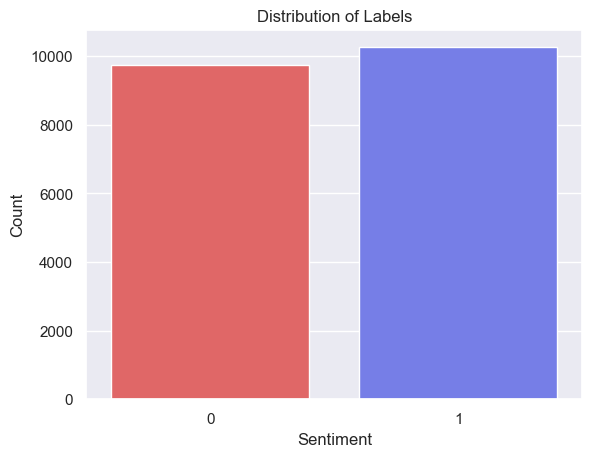

In [40]:
# Display distribution of labels
sns.set(style="darkgrid")
palette = {1: '#636efa', 0: '#f45353'}  # Define colors for each sentiment

sns.countplot(data=df, x='Label', palette=palette)
plt.title('Distribution of Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [39]:
# Display example reviews
print("Example Negative Review:")
print(df[df['Label'] == 0]['Text'].iloc[57])
print("\nExample Positive Review:")
print(df[df['Label'] == 1]['Text'].iloc[23])

Example Negative Review:
yet another example superb book done serious disservice e book publisher multiple spelling error improperly placed figure caption whole section book written cap reason looking excellent reference traditional timber framing look please pick print version instead e book

Example Positive Review:
book worth keep collection advise sourdough ruth also told picture past 100 year ago alaska stand mixer civilized stuff kitchen pot sourdough


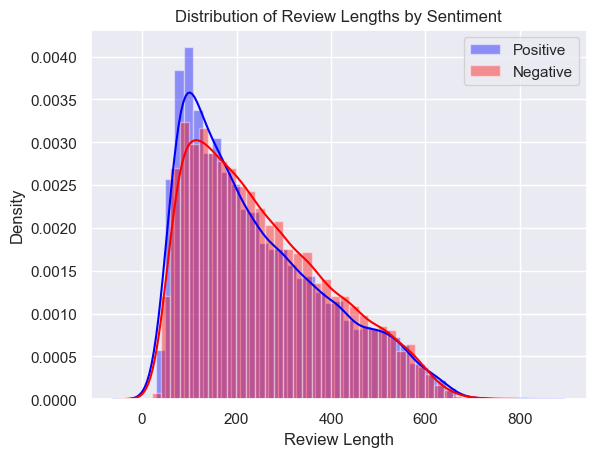

In [43]:
# Calculate the lengths of the reviews
positive_lengths = [len(text) for text, label in zip(texts, labels) if label == 1]
negative_lengths = [len(text) for text, label in zip(texts, labels) if label == 0]

# Create distplot
sns.distplot(positive_lengths, label='Positive', color='blue')
sns.distplot(negative_lengths, label='Negative',color='red')

plt.xlabel('Review Length')
plt.ylabel('Density')
plt.title('Distribution of Review Lengths by Sentiment')
plt.legend()

plt.show()

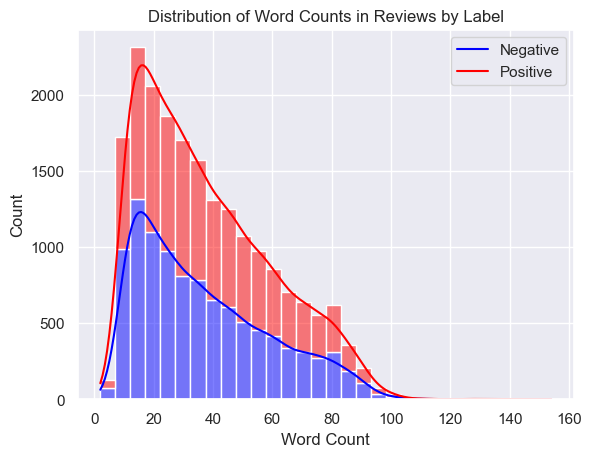

In [68]:
# Explore word count distribution in reviews
df['Word Count'] = df['Text'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x='Word Count', hue='Label', bins=30, multiple='stack', kde=True, palette={0: 'red', 1: 'blue'})
plt.title('Distribution of Word Counts in Reviews by Label')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.legend(['Negative', 'Positive'])
plt.show()

In [54]:
df.head()

,Text,Label,Text Length,Word Count
0,sound track beautiful paint senery mind well w...,1,254,40
1,reading lot review saying best game soundtrack...,1,276,42
2,soundtrack favorite music time hand intense sa...,1,477,68
3,truly like soundtrack enjoy video game music p...,1,511,73
4,played game know divine music every single son...,1,264,41
